# Group Selectivity PSTH Quick Plot

This notebook demonstrates the use of the `plot.group_psth` function to plot a group PSTH.

## Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
%pylab --no-import-all
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
import datajoint as dj

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [3]:
from pipeline import psth
from pipeline import plot
from pipeline import ephys

Connecting chris@localhost:3306


In [5]:
UnitPsth = psth.UnitPsth()
Selectivity = psth.Selectivity()
TrialCondition = psth.TrialCondition()

In [6]:
conds_i = (TrialCondition
           & {'condition_desc': 'audio delay ipsi hit'}).fetch('KEY')

conds_c = (TrialCondition
           & {'condition_desc': 'audio delay contra hit'}).fetch('KEY')

In [8]:
sel_i = Selectivity & Selectivity.selective & Selectivity.ipsi_preferring  # Ipsi
sel_c = Selectivity & Selectivity.selective & Selectivity.contra_preferring  # Contra

In [9]:
psth_i_i = ((UnitPsth.Unit & conds_i) & sel_i.proj()).fetch()
psth_i_c = ((UnitPsth.Unit & conds_c) & sel_i.proj()).fetch()

psth_c_c = ((UnitPsth.Unit & conds_c) & sel_c.proj()).fetch()
psth_c_i = ((UnitPsth.Unit & conds_i) & sel_c.proj()).fetch()

In [10]:
def movmean(data, nsamp=5):
    ret = np.cumsum(data, dtype=float)
    ret[nsamp:] = ret[nsamp:] - ret[:-nsamp]
    return ret[nsamp - 1:] / nsamp

In [11]:
def group_psth_ll(psth_a, psth_b, invert=False):
    plt_xmin, plt_xmax = -3, 3
    
    assert len(psth_a) == len(psth_b)
    nunits = len(psth_a)
    aspect = 2 / nunits
    extent = [plt_xmin, plt_xmax, 0, nunits]

    a_data = np.array([r[0] for r in psth_a['unit_psth']])
    b_data = np.array([r[0] for r in psth_b['unit_psth']])
    
    # scale per-unit psth's - TODO: moving average scaling
    a_data = np.array([movmean(i * (1 / np.max(i))) for i in a_data])
    b_data = np.array([movmean(i * (1 / np.max(i))) for i in b_data])
    
    if invert:
        result = (a_data - b_data) * -1
    else:
        result = a_data - b_data
    
    ax = plt.subplot(111)
    
    # ax.set_axis_off()
    ax.set_xlim([plt_xmin, plt_xmax])
    ax.axvline(0, 0, 1, ls='--', color='k')
    ax.axvline(-1.2, 0, 1, ls='--', color='k')
    ax.axvline(-2.4, 0, 1, ls='--', color='k')

    plt.imshow(result, cmap=plt.cm.bwr, aspect=aspect, extent=extent)

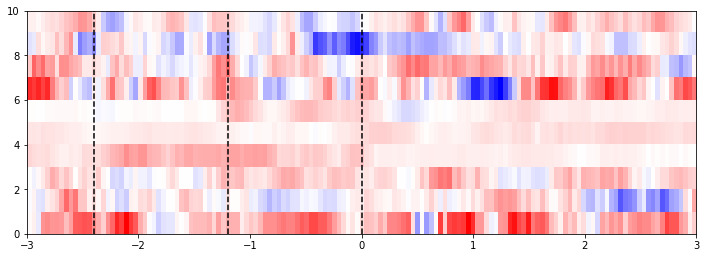

In [12]:
group_psth_ll(psth_i_i, psth_i_c)

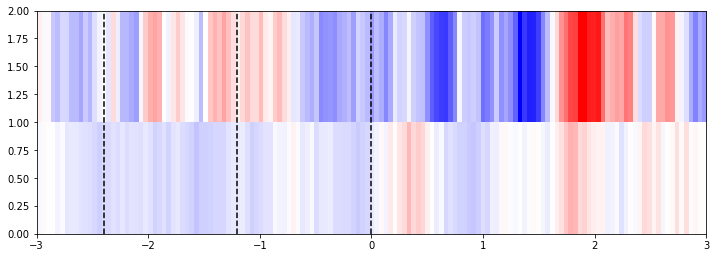

In [13]:
group_psth_ll(psth_c_i, psth_c_c, invert=True)